In [1]:
import numpy as np
import pennylane as qml

from vqe_utils import *

# Variational Quantum Eigensolver (VQE)

In these examples the number of qubits $n$ will be 2 or 3.

In [2]:
# example data
with open("100-2.in") as f:
    in2 = f.read()
# read function provided by QHack
H = parse_hamiltonian_input(in2)

In [3]:
num_qubits = len(H.wires)
print(num_qubits)

2


The computational basis is $|\phi_0>=|00>$, $|\phi_1>=10>$, etc. This gives us $N=2^n$ computational basis states.

Any other states of interest will be linear combinations (superpositions) of these basis states:
$$ |\psi> = \sum_i^N c_{i} |\phi_i> $$
where $c_{i}$ are complex numbers (with the restriction $\sum_i c_i^* c_i = 1$).

$H$ is a matrix $N\times N$ that can describes the interactions between the states of the computational basis. $H$ can be decomposed into products of the Pauli operators (e.g. $X_0X_1$, $X_0Z_2$, $Z_0Y_1X_2$, etc) and the expectation of these operators can be calculated on quantum computers.

In [4]:
print(in2)

+ 32.7658547225 I S - 2.1433035249352805 X1 S - 2.1433035249352805 Z0 X1 S + 17.015854722500002 Z1 S + 3.913118960624632 X0 Z1 S - 23.359145277499998 Z0 Z1 S - 3.913118960624632 X0 S - 26.859145277499998 Z0


The eigenstates of $H$ are $|\Psi_0>$, ...
where $H|\Psi_i>=E_i|\Psi_i>$, with $E_i$ the energies of the system.

Eigenstates can be expressed as linear combinations of basis states.
$$ |\psi_j> = \sum_i^N c_{ij} |\phi_i> $$

Equivalently, a basis state can be transformed (rotated) into an arbitrary state by a unitary transformation $U(\theta)$. $$|\psi(\theta)> := U(\theta)|\phi_0>$$
$\theta$ is an alternate set of parameters ($c_{ij}=c_{ij}(\theta)$)

We can find the ground-state $|\psi_0>$  by finding $\theta=\theta_0$ such that $|\psi(\theta_0)>=|\psi_0>$.

This means minimizing $E(\theta)=<\phi_0|U^\dagger(\theta)HU(\theta)|\phi_0>$, so we can treat $E(\theta)$ as the cost of an optimization problem.

The ground state energy is the "optimal value"
$$E_0 = \min_\theta <\phi_0|U^\dagger(\theta)HU(\theta)|\phi_0>$$

## VQE-100: Given $H$ and $U(\theta)$ find $\theta_{gs}$ corresponding to the ground state of $H$

Here we are given an ansatz. Given the normalization condition of $c$ our circuit only need $2^n-1$ complex parameters. The given ansatz has $(2^n-1)\times3$ real angles which should be enough.

In [5]:
num_param_sets = (2 ** num_qubits) - 1
params = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=(num_param_sets, 3))

In [6]:
def variational_ansatz(params, wires):
    """
    DO NOT MODIFY anything in this function! It is used to judge your solution.

    This is ansatz is used to help with the problem structure. It applies
    alternating layers of rotations and CNOTs.

    Don't worry about the contents of this function for now—you'll be designing
    your own ansatze in a later problem.

    Args:
        params (np.ndarray): An array of floating-point numbers with size (n, 3),
            where n is the number of parameter sets required (this is determined by
            the problem Hamiltonian).
        wires (qml.Wires): The device wires this circuit will run on.
    """
    n_qubits = len(wires)
    n_rotations = len(params)

    if n_rotations > 1:
        n_layers = n_rotations // n_qubits
        n_extra_rots = n_rotations - n_layers * n_qubits

        # Alternating layers of unitary rotations on every qubit followed by a
        # ring cascade of CNOTs.
        for layer_idx in range(n_layers):
            layer_params = params[layer_idx * n_qubits : layer_idx * n_qubits + n_qubits, :]
            qml.broadcast(qml.Rot, wires, pattern="single", parameters=layer_params)
            qml.broadcast(qml.CNOT, wires, pattern="ring")

        # There may be "extra" parameter sets required for which it's not necessarily
        # to perform another full alternating cycle. Apply these to the qubits as needed.
        extra_params = params[-n_extra_rots:, :]
        extra_wires = wires[: n_qubits - 1 - n_extra_rots : -1]
        qml.broadcast(qml.Rot, extra_wires, pattern="single", parameters=extra_params)
    else:
        # For 1-qubit case, just a single rotation to the qubit
        qml.Rot(*params[0], wires=wires[0])

To execute the circuit we need a `quantum device`

In [7]:
dev = qml.device("qiskit.aer", wires=num_qubits)

Define the cost function with `ExpvalCost`

In [8]:
cost = qml.ExpvalCost(variational_ansatz, H, dev)

Initial energy:

In [9]:
print(cost(params))

4.197208132373781


What the circuit looks like:

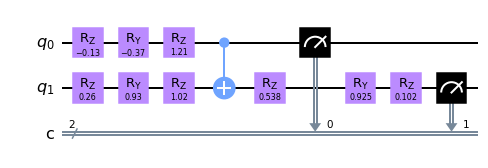

In [10]:
@qml.qnode(dev)
def circuit(params):
    variational_ansatz(params,dev.wires)
    return qml.expval(qml.Identity(0))
result = circuit(params)
dev._circuit.draw('mpl')

Combine into a function and iterate `opt.step(cost)` to update parameters

In [11]:
def run_vqe(H):
    """Runs the variational quantum eigensolver on the problem Hamiltonian using the
    variational ansatz specified above.

    Fill in the missing parts between the # QHACK # markers below to run the VQE.

    Args:
        H (qml.Hamiltonian): The input Hamiltonian

    Returns:
        The ground state energy of the Hamiltonian.
    """
    # Initialize parameters
    num_qubits = len(H.wires)
    num_param_sets = (2 ** num_qubits) - 1
    params = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=(num_param_sets, 3))

    energy = 0

    # QHACK #

    # Create a quantum device, set up a cost funtion and optimizer, and run the VQE.
    # (We recommend ~500 iterations to ensure convergence for this problem,
    # or you can design your own convergence criteria)
    dev = qml.device("default.qubit", wires=num_qubits)

    cost = qml.ExpvalCost(variational_ansatz, H, dev)

    opt = qml.GradientDescentOptimizer(0.1)
    #opt = qml.AdamOptimizer()
    
    max_iter = 200
    
    for i in range(max_iter):
        if i % 20 == 0: print(f"step {i}, cost {cost(params)}")
        params = opt.step(cost, params)

    energy = cost(params)

    # QHACK #

    # Return the ground state energy
    return energy

In [12]:
with open("100-1.in") as f:
    in1 = f.read()
print(in1)

+ 5.906709445000001 I S - 4.286607049870561 X0 S - 6.343290554999999 Z0


In [13]:
# Turn input to Hamiltonian
H = parse_hamiltonian_input(in1)

# Send Hamiltonian through VQE routine and output the solution
ground_state_energy = run_vqe(H)
print(f"{ground_state_energy:.6f}")

step 0, cost 0.6005488653039261
step 20, cost -1.7491593320420646
step 40, cost -1.749159876312238
step 60, cost -1.7491598763215297
step 80, cost -1.7491598763215284
step 100, cost -1.7491598763215284
step 120, cost -1.7491598763215284
step 140, cost -1.7491598763215284
step 160, cost -1.7491598763215284
step 180, cost -1.7491598763215284
-1.749160


In [14]:
with open("100-1.ans") as f:
    ans1 = f.read()
print(ans1)

-1.749160



In [15]:
with open("100-2.in") as f:
    in2 = f.read()
print(in2)

+ 32.7658547225 I S - 2.1433035249352805 X1 S - 2.1433035249352805 Z0 X1 S + 17.015854722500002 Z1 S + 3.913118960624632 X0 Z1 S - 23.359145277499998 Z0 Z1 S - 3.913118960624632 X0 S - 26.859145277499998 Z0


In [16]:
# Turn input to Hamiltonian
H = parse_hamiltonian_input(in2)

# Send Hamiltonian through VQE routine and output the solution
ground_state_energy = run_vqe(H)
print(f"{ground_state_energy:.6f}")

step 0, cost 19.931088153444332
step 20, cost -1.9376457874864066
step 40, cost -1.9444587940919291
step 60, cost -1.952310127341157
step 80, cost -1.9620014958826282
step 100, cost -1.972874755544538
step 120, cost -1.9842148752028201
step 140, cost -1.9956785719391767
step 160, cost -2.00694366881061
step 180, cost -2.0173704761886597
-2.026214


In [17]:
with open("100-2.ans") as f:
    ans1 = f.read()
print(ans1)

-2.045671


## VQE-200: Designing an ansatz $U(\theta)$

Suppose we know that the eigenstate must have a particular form.

We might want to map the quantum states of our basis to a one-hot encoding.

$$ \left\vert \psi(\alpha) \right\rangle = \alpha_0 \left\vert 100\cdots0 \right\rangle + \alpha_1 \left\vert 010\cdots0 \right\rangle + \cdots + \alpha_{n-2} \left\vert 0\cdots010 \right\rangle + \alpha_{n-1} \left\vert 0\cdots001 \right\rangle $$

where $\alpha_i$ are *real* numbers.

The strategy for this circuit is to iteratively apply Xs and RYs. The X flips one qubit from |0> into state |1> or vice-versa. The RY is a real number because Y is entirely imaginary ($RY(\theta)=e^{i\theta Y}$).

This means we only need $2^n-1$ angles!

Below we'll use $c$ and $s$ as shorthand for $\cos$ and $\sin$.

Base case:

$X_0|00> = |10>$

$RY(\theta)_1|10> = c(\theta)|10> + s(\theta)|11>$

Then entangle (using the CNOT (also known as CX) to swap $q_0$ back to 0:

$CNOT(0,1)(c(\theta)|10> + s(\theta)|11>) = c(\theta)|10> + s(\theta)|01>$

For more qubits we use controlled rotations (CRY) to rotate the $i$th qubit on the term with 1 in $i-1$ qubit and then use a CNOT on the opposite wires to unflip the $i-1$th qubit.

Iterate:
<code>
for i in range(2,num_qubits):
    CRY(i-1,1)
    CNOT(i,i-1)
</code>


Example:

$CRY(\theta',1,2)[c(\theta)|100> + s(\theta)|010>] = c(\theta)|100> + s(\theta)[ c(\theta') |010> + s(\theta') |011> ]$

$CNOT(2,1)[c(\theta)|100> + s(\theta)[ c(\theta') |010> + s(\theta') |011> ] = c(\theta)|100> + s(\theta)c(\theta') |010> + s(\theta)s(\theta') |001>$

In [18]:
def variational_ansatz(params, wires):
    """The variational ansatz circuit.

    Fill in the details of your ansatz between the # QHACK # comment markers. Your
    ansatz should produce an n-qubit state of the form

        a_0 |10...0> + a_1 |01..0> + ... + a_{n-2} |00...10> + a_{n-1} |00...01>

    where {a_i} are real-valued coefficients.

    Args:
         params (np.array): The variational parameters.
         wires (qml.Wires): The device wires that this circuit will run on.
    """

    # QHACK #
    n_qubits = len(wires)
    qml.PauliX(wires=0)
    qml.RY(params[0], wires=1)
    qml.CNOT(wires=[1,0])

    if n_qubits > 2:
        for i in range(2,n_qubits):
            qml.CRY(params[i-1], wires=[i-1,i])
            qml.CNOT(wires=[i,i-1])
    # QHACK #

+ 15.531709 I S + 0.218291 Z0 S - 6.125 Z1 S - 2.143304 X0 X1 S - 2.143304 Y0 Y1 S - 9.625 Z2 S - 3.913119 X1 X2 S - 3.913119 Y1 Y2


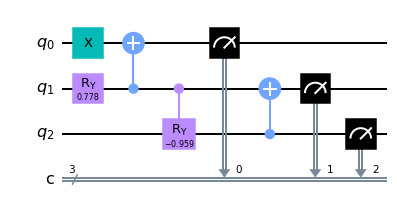

In [19]:
###############
with open("200-2.in") as f:
    in2 = f.read()
print(in2)
# Turn input to Hamiltonian
H = parse_hamiltonian_input(in2)
# Initialize the quantum device
num_qubits = len(H.wires)
dev = qml.device("qiskit.aer", wires=num_qubits)
###############

# Randomly choose initial parameters (how many do you need?)
params = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=(num_qubits-1))
@qml.qnode(dev)
def circuit(params):
    variational_ansatz(params,dev.wires)
    return qml.expval(qml.Identity(0))
result = circuit(params)
dev._circuit.draw('mpl')

In [20]:
def run_vqe(H):
    """Runs the variational quantum eigensolver on the problem Hamiltonian using the
    variational ansatz specified above.

    Fill in the missing parts between the # QHACK # markers below to run the VQE.

    Args:
        H (qml.Hamiltonian): The input Hamiltonian

    Returns:
        The ground state energy of the Hamiltonian.
    """
    energy = 0

    # QHACK #

    # Initialize the quantum device
    num_qubits = len(H.wires)
    dev = qml.device("default.qubit", wires=num_qubits)

    # Randomly choose initial parameters (how many do you need?)
    params = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=(num_qubits-1))

    # Set up a cost function
    cost = qml.ExpvalCost(variational_ansatz, H, dev)

    # Set up an optimizer
    opt = qml.GradientDescentOptimizer(0.1)

    max_iter = 400
    # Run the VQE by iterating over many steps of the optimizer
    for i in range(max_iter):
        if i % 50 == 0: print(f"step {i}, cost {cost(params)}")
        params = opt.step(cost, params)

    energy = cost(params)

    # QHACK #

    # Return the ground state energy
    return energy

In [21]:
with open("200-1.in") as f:
    in1 = f.read()
print(in1)

# Turn input to Hamiltonian
H = parse_hamiltonian_input(in1)

# Send Hamiltonian through VQE routine and output the solution
ground_state_energy = run_vqe(H)
print(f"{ground_state_energy:.6f}")

with open("200-1.ans") as f:
    ans1 = f.read()
print(f"Answer: {ans1}")

+ 5.906709 I S + 0.218291 Z0 S - 6.125 Z1 S - 2.143304 X0 X1 S - 2.143304 Y0 Y1
step 0, cost 7.3195395985491825
step 50, cost -1.7491612220155868
step 100, cost -1.7491612220155868
step 150, cost -1.7491612220155868
step 200, cost -1.7491612220155868
step 250, cost -1.7491612220155868
step 300, cost -1.7491612220155868
step 350, cost -1.7491612220155868
-1.749161
Answer: -1.749160



In [22]:
with open("200-2.in") as f:
    in2 = f.read()
print(in2)

# Turn input to Hamiltonian
H = parse_hamiltonian_input(in2)

# Send Hamiltonian through VQE routine and output the solution
ground_state_energy = run_vqe(H)
print(f"{ground_state_energy:.6f}")

with open("200-2.ans") as f:
    ans2 = f.read()
print(f"Answer: {ans2}")

+ 15.531709 I S + 0.218291 Z0 S - 6.125 Z1 S - 2.143304 X0 X1 S - 2.143304 Y0 Y1 S - 9.625 Z2 S - 3.913119 X1 X2 S - 3.913119 Y1 Y2
step 0, cost 0.14517100617468592
step 50, cost -2.045672285536692
step 100, cost -2.04567228767709
step 150, cost -2.0456722876770868
step 200, cost -2.0456722876770908
step 250, cost -2.0456722876770908
step 300, cost -2.0456722876770908
step 350, cost -2.0456722876770908
-2.045672
Answer: -2.045671


## VQE-500: Find the excited states of $H$

VQE as described in the above seems very limited compared to classical diagonalization. We also want the excited states in order to fully describe real systems (e.g. molecules, nuclei).

### Attempt #1: Variational Quantum Deflation

One strategy is to iterate VQE but modify the cost function to force the lowest state to be orthogonal to all the previously found states.

In [23]:
# Steal ansatz from VQE-100
def U(params,wires):
    n_qubits = len(wires)
    n_rotations = len(params)

    if n_rotations > 1:
        n_layers = n_rotations // n_qubits
        n_extra_rots = n_rotations - n_layers * n_qubits

        # Alternating layers of unitary rotations on every qubit followed by a
        # ring cascade of CNOTs.
        for layer_idx in range(n_layers):
            layer_params = params[layer_idx * n_qubits : layer_idx * n_qubits + n_qubits, :]
            qml.broadcast(qml.Rot, wires, pattern="single", parameters=layer_params)
            qml.broadcast(qml.CNOT, wires, pattern="ring")

        # There may be "extra" parameter sets required for which it's not necessarily
        # to perform another full alternating cycle. Apply these to the qubits as needed.
        extra_params = params[-n_extra_rots:, :]
        extra_wires = wires[: n_qubits - 1 - n_extra_rots : -1]
        qml.broadcast(qml.Rot, extra_wires, pattern="single", parameters=extra_params)
    else:
        # For 1-qubit case, just a single rotation to the qubit
        qml.Rot(*params[0], wires=wires[0])

In order to do this we need to calculate the overlap between states created by different transformations .i.e. $<\psi(\theta)|\psi(\theta')>=<\phi_0|U^\dagger(\theta)U(\theta')|\phi_0>$. One way to do this is to get the state (only available with a classical simulator), and construct the density matrix $|\psi(\theta)><\psi(\theta)|$ which we can add as a term to the Hamiltonian.

In [24]:
###############
# example data
with open("200-2.in") as f:
    in2 = f.read()
#print(in2)
# Turn input to Hamiltonian
H = parse_hamiltonian_input(in2)
# Initialize the quantum device
num_qubits = len(H.wires)
dev = qml.device("default.qubit", wires=num_qubits)
# Randomly choose initial parameters
params = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=(num_qubits-1,3))
###############

# needed to use qml.state
qml.enable_tape()

# get_state function
@qml.qnode(dev)
def get_state(params):
    U(params, dev.wires)
    return qml.state()

# construct overlap Hamiltonian
state = get_state(params)
dens_matrix = np.outer(state.conj(), state)
overlap_Ham = qml.Hamiltonian(coeffs=[1.,], observables=[qml.Hermitian(dens_matrix, dev.wires),])

# Set up a cost function
cost = qml.ExpvalCost(variational_ansatz, H + overlap_Ham, dev)

In [25]:
def find_excited_states(H):
    """
    Fill in the missing parts between the # QHACK # markers below. Implement
    a variational method that can find the three lowest energies of the provided
    Hamiltonian.

    Args:
        H (qml.Hamiltonian): The input Hamiltonian

    Returns:
        The lowest three eigenenergies of the Hamiltonian as a comma-separated string,
        sorted from smallest to largest.
    """

    energies = np.zeros(3)

    # QHACK #
    num_qubits = len(H.wires)
    #print(H.wires)
    num_param_sets = (2 ** num_qubits) - 1
    saved_params = []

    dev = qml.device("default.qubit", wires=num_qubits)

    # circuit from vqe-100
    def variational_ansatz(params, wires):
        n_qubits = len(wires)
        n_rotations = len(params)

        if n_rotations > 1:
            n_layers = n_rotations // n_qubits
            n_extra_rots = n_rotations - n_layers * n_qubits

            # Alternating layers of unitary rotations on every qubit followed by a
            # ring cascade of CNOTs.
            for layer_idx in range(n_layers):
                layer_params = params[layer_idx * n_qubits : layer_idx * n_qubits + n_qubits]
                if layer_idx == 0:
                  qml.broadcast(qml.RY, wires, pattern="single", parameters=layer_params)
                else:
                  qml.broadcast(qml.CNOT, wires, pattern="ring")
                  qml.broadcast(qml.RY, wires, pattern="single", parameters=layer_params)

            # There may be "extra" parameter sets required for which it's not necessarily
            # to perform another full alternating cycle. Apply these to the qubits as needed.
            extra_params = params[-n_extra_rots:]
            extra_wires = wires[: n_qubits - 1 - n_extra_rots : -1]
            extra_wires2 = wires[: n_qubits - 2 - n_extra_rots : -1]
            #print("ew",extra_wires)
            #print("test",extra_wires2)
            if n_qubits > 2:
                qml.broadcast(qml.CNOT, extra_wires2, pattern="ring")
            else:
                qml.broadcast(qml.CNOT, [1,0], pattern='chain')
            qml.broadcast(qml.RY, extra_wires, pattern="single", parameters=extra_params)
        else:
            # For 1-qubit case, just a single rotation to the qubit
            qml.RY(params[0], wires=wires[0])

    params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(num_param_sets))

    # find ground state
    cost0 = qml.ExpvalCost(variational_ansatz, H, dev)

    #opt = qml.GradientDescentOptimizer(0.1)
    opt = qml.AdamOptimizer(0.1)
    #opt = qml.AdagradOptimizer(0.1)

    #print(H.wires)

    min_50 = np.inf
    for i in range(500):
        if i % 50 == 0: 
            if abs(cost0(params)-min_50)<1e-4: break
            min_50 = cost0(params)
            print(f"step {i}, E_0 {cost0(params)}")
        params = opt.step(cost0, params)

    energies[0] = cost0(params)
    saved_params.append(params)
    #print(energies[0],cost0(params))

    # function for overlaps
    qml.enable_tape()

    @qml.qnode(dev)
    def get_state(params):
        variational_ansatz(params, dev.wires)
        return qml.state()
     
    overlap_state1 = get_state(params)
    overlap_herm1 = np.outer(overlap_state1.conj(), overlap_state1)
    #print("psi_0",overlap_state1)
    #print(overlap_herm1)

    # find the first excited
    params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(num_param_sets))
    a = 100 # big number to enforce orthogonality
    overlap_Ham = qml.Hamiltonian(coeffs=[a,], observables=[qml.Hermitian(overlap_herm1,dev.wires),])
    #print("a|psi_0><psi_0",overlap_Ham,overlap_Ham.ops)
    H1 = H + overlap_Ham
    #print("H1",H1)
    cost = qml.ExpvalCost(variational_ansatz, H1, dev)# + qml.ExpvalCost(variational_ansatz, overlap_Ham, dev)
    #print(cost(saved_params[0]),a+energies[0],a+cost0(saved_params[0]))

    min_50 = np.inf
    for i in range(1500):
        if i % 50 == 0: 
            if abs(cost0(params)-min_50)<1e-4: break
            print(f"step {i}, E_1 {cost0(params)}, cost {cost(params)}")
            min_50 = cost0(params)
        params = opt.step(cost, params)  

    energies[1] = cost0(params)
    saved_params.append(params)
    #print(energies[1],cost(params))

    overlap_state2 = get_state(params)
    overlap_herm2 = np.outer(overlap_state2.conj(), overlap_state2)
    #print("|psi_1>",overlap_state2)
    #print(overlap_herm2)

    # find the second excited    
    params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(num_param_sets))
    b = 100
    overlap_Ham = qml.Hamiltonian(coeffs=[a,b], observables=[qml.Hermitian(overlap_herm1,dev.wires),qml.Hermitian(overlap_herm2,dev.wires)])
    #print("a|psi_0><psi_0|+b|psi_1><psi_1",overlap_Ham,overlap_Ham.ops)
    H2 = H + overlap_Ham
    #print("H2",H2)
    cost = qml.ExpvalCost(variational_ansatz, H2, dev)# + qml.ExpvalCost(variational_ansatz, overlap_Ham, dev)

    min_50 = np.inf
    for i in range(1500):
        if i % 50 == 0: 
            if abs(cost0(params)-min_50)<1e-4: break
            print(f"step {i}, E_2 {cost0(params)}, cost {cost(params)}")
            min_50 = cost0(params)
        params = opt.step(cost, params)  

    energies[2] = cost0(params)
    saved_params.append(params)

    # QHACK #

    return ",".join([str(E) for E in energies])

In [26]:
with open("500-1.in") as f:
    in1 = f.read()
print(in1)

# Turn input to Hamiltonian
H = parse_hamiltonian_input(in1)

# Send Hamiltonian through VQE routine and output the solution
lowest_three_energies = find_excited_states(H)
print(f"Found energies: {lowest_three_energies}")

with open("500-1.ans") as f:
    ans1 = f.read()
print(f"Answer: {ans1}")

+ 0.35807927646889326 X0 S + 0.7556205249987815 X1 S + 0.04828309125493235 X2 S + 0.07927207111541623 Z1 Z2

step 0, E_0 0.23379649861502383
step 50, E_0 -1.1615170131482684
step 100, E_0 -1.165855704213429
step 0, E_1 0.46322458214169926, cost 7.059064168528456
step 50, E_1 0.3241390085728521, cost 0.3354668880345858
step 100, E_1 -0.7079621615514267, cost -0.7077446265272981
step 150, E_1 -1.0457902767127638, cost -1.0457879512289308
step 200, E_1 -1.0697814580041722, cost -1.0697814429900874
step 0, E_2 -0.0784343911577137, cost 15.549097766640736
step 50, E_2 -0.20862319901649137, cost -0.20042269199370533
step 100, E_2 -0.449093339145584, cost -0.449031492323184
step 150, E_2 -0.4497233665772353, cost -0.4497232433894736
Found energies: -1.1658817260840566,-1.069844667035752,-0.4497233717591518
Answer: -1.1658819,-1.0698449,-0.44972335



In [27]:
with open("500-2.in") as f:
    in2 = f.read()
print(in2)

# Turn input to Hamiltonian
H = parse_hamiltonian_input(in2)

# Send Hamiltonian through VQE routine and output the solution
lowest_three_energies = find_excited_states(H)
print(f"Found energies: {lowest_three_energies}")

with open("500-2.ans") as f:
    ans2 = f.read()
print(f"Answer: {ans2}")

+ 0.4977616234240615 X0 S + 0.5635396435844906 X1 S + 0.32588875859719557 Z1 Z2 S + 0.18913602999217294 X2
step 0, E_0 0.5648404082834588
step 50, E_0 -1.3113663357698402
step 100, E_0 -1.317911692114431
step 0, E_1 0.5125939937094064, cost 10.564831902421433
step 50, E_1 -0.4124408316742335, cost -0.3598820467858801
step 100, E_1 -0.7679478352132572, cost -0.7678324428420006
step 150, E_1 -0.8224078393654628, cost -0.8223994972592418
step 200, E_1 -0.8432390736254756, cost -0.8432388921239258
step 250, E_1 -0.9073104551313573, cost -0.9073103856722987
step 300, E_1 -0.9935135575857413, cost -0.9934730410144748
step 350, E_1 -0.9941250991016186, cost -0.9941239037020866
step 0, E_2 0.4732332857608226, cost 30.66863575980565
step 50, E_2 0.27214575056074186, cost 0.28293867788489047
step 100, E_2 -0.31151673273212765, cost -0.31084779004833535
step 150, E_2 -0.3209222836279214, cost -0.32091826881736524
step 200, E_2 -0.32170268459194834, cost -0.3217025539025113
step 250, E_2 -0.322147

### Attempt #2: Weighted Subspace-search VQE

Because $U(\theta)$ is unitary and the initial states are orthogonal the states that $U$ transforms these to are also orthogonal (even if they are not the true eigenstates).

$|\psi_0> = U|\phi_0>$, $|\psi_1> = U|\phi_1>$

$$ <\psi_0 | \psi_1 > = <\phi_0| U^\dagger U |phi_1> = <\phi_0 | \phi_1> =0$$

This means we can simulataneously find eigenstates by finding a single $U(theta)$. We do this by simultaneously minimizing the expectation values of $U$ on multiple input states i.e. $<H_i>=<\phi_i|U^\dagger(\theta)HU(\theta)|\phi_i>$.

We get the bottom three in the correct order by weighting each expectation in order.

Cost: $\sum_{i=0}^3 w_i <H_i>$ with $w_0>w_1>w_2$

In [28]:
def find_excited_states(H):
    """
    Fill in the missing parts between the # QHACK # markers below. Implement
    a variational method that can find the three lowest energies of the provided
    Hamiltonian.

    Args:
        H (qml.Hamiltonian): The input Hamiltonian

    Returns:
        The lowest three eigenenergies of the Hamiltonian as a comma-separated string,
        sorted from smallest to largest.
    """

    energies = np.zeros(3)

    # QHACK #
    num_qubits = len(H.wires)

    def phi0():
        qml.PauliX(0)

    def phi1():
        qml.PauliX(1)

    def phi2():
        qml.PauliX(2)

    def U(params,wires):
        n_qubits = len(wires)
        n_rotations = len(params)

        if n_rotations > 1:
            n_layers = n_rotations // n_qubits
            n_extra_rots = n_rotations - n_layers * n_qubits

            # Alternating layers of unitary rotations on every qubit followed by a
            # ring cascade of CNOTs.
            for layer_idx in range(n_layers):
                layer_params = params[layer_idx * n_qubits : layer_idx * n_qubits + n_qubits, :]
                qml.broadcast(qml.Rot, wires, pattern="single", parameters=layer_params)
                qml.broadcast(qml.CNOT, wires, pattern="ring")

            # There may be "extra" parameter sets required for which it's not necessarily
            # to perform another full alternating cycle. Apply these to the qubits as needed.
            extra_params = params[-n_extra_rots:, :]
            extra_wires = wires[: n_qubits - 1 - n_extra_rots : -1]
            qml.broadcast(qml.Rot, extra_wires, pattern="single", parameters=extra_params)
        else:
            # For 1-qubit case, just a single rotation to the qubit
            qml.Rot(*params[0], wires=wires[0])
        
    def ansatz0(params,wires):
        phi0()
        U(params,wires)
    def ansatz1(params,wires):
        phi1()
        U(params,wires)
    def ansatz2(params,wires):
        phi2()
        U(params,wires)

    num_param_sets = (2 ** num_qubits) - 1

    dev = qml.device("default.qubit",wires=num_qubits)

    def cost(params):
        E0 = qml.ExpvalCost(ansatz0, 3*H, dev).__call__(params)
        E1 = qml.ExpvalCost(ansatz1, 2*H, dev).__call__(params)
        E2 = qml.ExpvalCost(ansatz2, 1*H, dev).__call__(params)
        return E0 + E1 + E2

    #opt = qml.AdamOptimizer(0.1)
    #opt = qml.MomentumOptimizer()
    #opt = qml.GradientDescentOptimizer(0.1)
    #opt = qml.AdagradOptimizer(0.1)
    opt = qml.RMSPropOptimizer()

    num_runs = 1
    max_iter = 400
    best_tot = np.inf
    best_energies = np.zeros(3)
    for j in range(num_runs):
        current_energies = np.zeros(3)
        params = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=(num_param_sets,3))
        for i in range(max_iter):
            if i % 50 == 0: print(f"step {i}, cost {cost(params)}")
            params = opt.step(cost, params)

        current_energies[0] = qml.ExpvalCost(ansatz0,H,dev).__call__(params)
        current_energies[1] = qml.ExpvalCost(ansatz1,H,dev).__call__(params)
        current_energies[2] = qml.ExpvalCost(ansatz2,H,dev).__call__(params)
        #print(current_energies)
        # walrus := not allowed :(
        #if (E:=np.sum(current_energies))<best_tot:
        if np.sum(current_energies)<best_tot:
            #print(E)
            best_tot = np.sum(current_energies)
            best_energies = current_energies
    
    energies = np.sort(best_energies)
    
    # QHACK #

    return ",".join([str(E) for E in energies])

In [29]:
with open("500-1.in") as f:
    in1 = f.read()
print(in1)

# Turn input to Hamiltonian
H = parse_hamiltonian_input(in1)

# Send Hamiltonian through VQE routine and output the solution
lowest_three_energies = find_excited_states(H)
print(f"Found energies: {lowest_three_energies}")

with open("500-1.ans") as f:
    ans1 = f.read()
print(f"Answer: {ans1}")

+ 0.35807927646889326 X0 S + 0.7556205249987815 X1 S + 0.04828309125493235 X2 S + 0.07927207111541623 Z1 Z2

step 0, cost 0.2626641265405162
step 50, cost -3.5056056673842075
step 100, cost -4.51691993440667
step 150, cost -4.64968053049057
step 200, cost -4.6538119821558395
step 250, cost -4.653952875011221
step 300, cost -4.653959792494961
step 350, cost -4.653887957001483
Found energies: -0.8077646214229003,-0.8076358877135189,-0.7116341128615323
Answer: -1.1658819,-1.0698449,-0.44972335



In [30]:
with open("500-2.in") as f:
    in2 = f.read()
print(in2)

# Turn input to Hamiltonian
H = parse_hamiltonian_input(in2)

# Send Hamiltonian through VQE routine and output the solution
lowest_three_energies = find_excited_states(H)
print(f"Found energies: {lowest_three_energies}")

with open("500-2.ans") as f:
    ans2 = f.read()
print(f"Answer: {ans2}")

+ 0.4977616234240615 X0 S + 0.5635396435844906 X1 S + 0.32588875859719557 Z1 Z2 S + 0.18913602999217294 X2
step 0, cost -0.12062597653989489
step 50, cost -3.655364987683033
step 100, cost -4.205704640591097
step 150, cost -4.585226734072355
step 200, cost -4.870395943662715
step 250, cost -4.907094536860151
step 300, cost -4.907247660645686
step 350, cost -4.907269164553093
Found energies: -1.311854626065161,-0.33859605924931346,-0.3165716634344967
Answer: -1.31795925,-0.99412998,-0.32243601
